Required Libraries

In [37]:
# This project aims to develop a machine learning model to predict equipment energy consumption based on sensor data collected from a smart manufacturing facility. The project includes data preprocessing, feature engineering, exploratory data analysis (EDA), model training (Random Forest and XGBoost), model evaluation, and insights.
# Note- We import essential Python libraries for data manipulation, visualization, model development, and evaluation.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Convert non-timestamp object columns to numeric and Handle missing values

In [39]:
def preprocess_data(df):
    for col in df.columns:
        if df[col].dtype == 'object' and col != 'timestamp':
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Parse timestamp and extract features
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['month'] = df['timestamp'].dt.month

    # Handle missing values
    df.fillna(df.median(numeric_only=True), inplace=True)
    df.dropna(subset=['equipment_energy_consumption'], inplace=True)

    return df

Function to evaluate model performance

In [40]:
def evaluate_model(name, y_true, y_pred):
    print(f"{name} Evaluation:")
    print(f"MAE:  {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")
    print(f"R^2:  {r2_score(y_true, y_pred):.4f}")
    print("-" * 30)

Function to plot feature importances

In [41]:
def evaluate_model(name, y_true, y_pred):
    print(f"{name} Evaluation:")
    print(f"MAE:  {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")
    print(f"R^2:  {r2_score(y_true, y_pred):.4f}")
    print("-" * 30)

# Function to plot feature importances
def plot_feature_importance(model, features):
    plt.figure(figsize=(10, 6))
    importances = model.feature_importances_
    sorted_idx = np.argsort(importances)
    sns.barplot(x=importances[sorted_idx], y=features[sorted_idx])
    plt.title("Feature Importances")
    plt.tight_layout()
    plt.show()



Load and explore data

In [42]:
df = pd.read_csv('/data.csv')
print(df.info())
print(df.describe())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16857 entries, 0 to 16856
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   timestamp                     16857 non-null  object 
 1   equipment_energy_consumption  16013 non-null  object 
 2   lighting_energy               16048 non-null  object 
 3   zone1_temperature             15990 non-null  object 
 4   zone1_humidity                16056 non-null  object 
 5   zone2_temperature             16004 non-null  object 
 6   zone2_humidity                15990 non-null  float64
 7   zone3_temperature             16055 non-null  float64
 8   zone3_humidity                15979 non-null  float64
 9   zone4_temperature             16041 non-null  float64
 10  zone4_humidity                16076 non-null  float64
 11  zone5_temperature             16019 non-null  float64
 12  zone5_humidity                16056 non-null  float64
 13  z

 Preprocess data

In [43]:
df = preprocess_data(df)

 Exploratory Data Analysis (EDA)

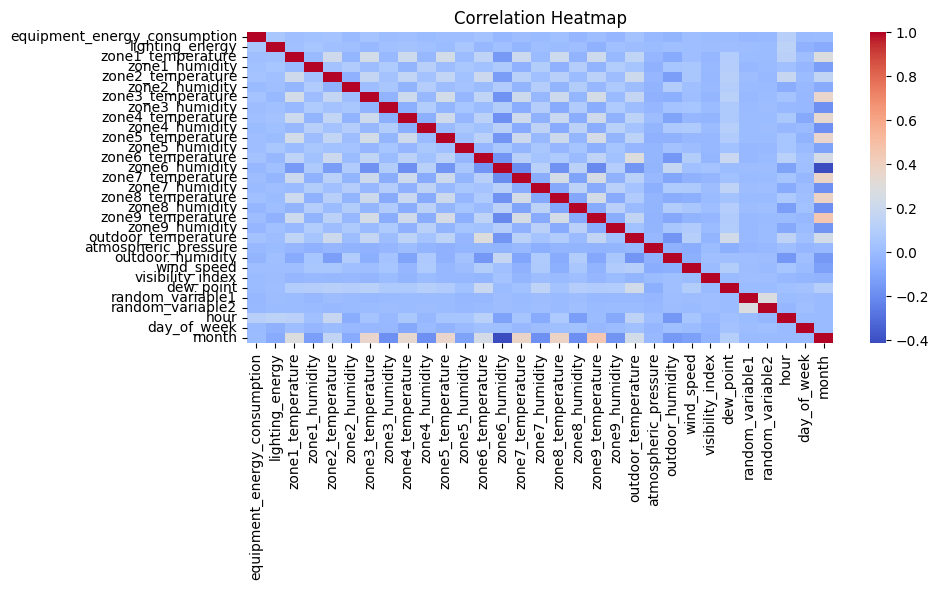

In [44]:
# Note- We examine the data using descriptive statistics and visualizations to understand variable relationships and identify patterns.

plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

Investigate correlation with target

In [45]:
corr_random_vars = df[['random_variable1', 'random_variable2', 'equipment_energy_consumption']].corr()
print("Correlation with target:\n", corr_random_vars)

Correlation with target:
                               random_variable1  random_variable2  \
random_variable1                      1.000000          0.280639   
random_variable2                      0.280639          1.000000   
equipment_energy_consumption         -0.015374         -0.010301   

                              equipment_energy_consumption  
random_variable1                                 -0.015374  
random_variable2                                 -0.010301  
equipment_energy_consumption                      1.000000  


Prepare features and target

In [24]:
drop_cols = ['timestamp', 'equipment_energy_consumption', 'random_variable1', 'random_variable2']
X = df.drop(columns=drop_cols)
y = df['equipment_energy_consumption']

Train-Test Split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Random Forest Model

In [46]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)




 XGBoost Model with Grid Search

In [31]:
# Note- We train two models: a baseline Random Forest Regressor and a tuned XGBoost Regressor using GridSearchCV. The models are evaluated using MAE, RMSE, and R².
# Define grid for hyperparameter tuning

grid_params = {
    'n_estimators': [100, 200],         # Number of trees
    'learning_rate': [0.05, 0.1],       # Step size shrinkage
    'max_depth': [3, 5]                 # Tree depth
}


grid_search = GridSearchCV(estimator=XGBRegressor(random_state=42),
                           param_grid=grid_params,
                           cv=5,
                           scoring='neg_root_mean_squared_error',
                           verbose=0)
grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_
xgb_preds = best_xgb.predict(X_test)

Cross-Validation Scores

In [32]:
cv_scores = cross_val_score(best_xgb, X_train, y_train, cv=5, scoring='r2')
print(f"XGBoost CV R^2 Scores: {cv_scores}")
print(f"Mean CV R^2 Score: {cv_scores.mean():.4f}")


XGBoost CV R^2 Scores: [0.04618298 0.06697499 0.08026973 0.07905018 0.0623029 ]
Mean CV R^2 Score: 0.0670


Evaluate Models

In [33]:
evaluate_model("Random Forest", y_test, rf_preds)
evaluate_model("XGBoost (Tuned)", y_test, xgb_preds)


Random Forest Evaluation:
MAE:  71.79
RMSE: 175.07
R^2:  0.0502
------------------------------
XGBoost (Tuned) Evaluation:
MAE:  70.66
RMSE: 174.04
R^2:  0.0613
------------------------------


Feature Importance Plot and save model


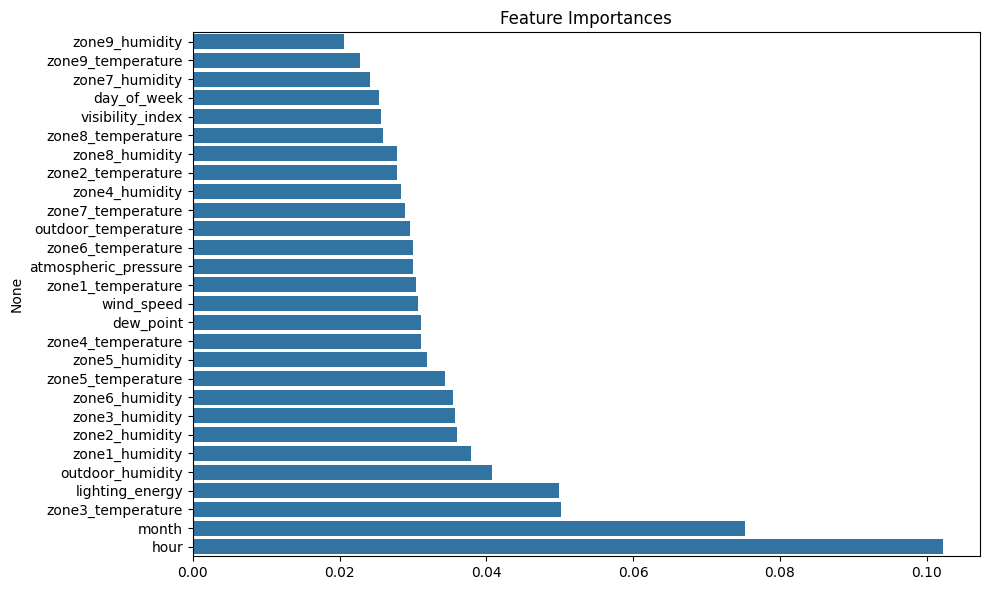

['outputs/models/xgb_model.pkl']

In [38]:
plot_feature_importance(best_xgb, X.columns)


# Ensure the directory exists
os.makedirs('outputs/models', exist_ok=True)

# Save the Best Model
joblib.dump(best_xgb, 'outputs/models/xgb_model.pkl')

